In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 normalization constants
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Standard preprocessing for val/test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Load full CIFAR-10 training data (50k images)
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Total dataset size (50,000 from train=True)
total_size = len(full_dataset)  # 50,000
train_size = int(0.70 * total_size)  # 35,000
val_size = int(0.15 * total_size)    # 7,500
test_size = total_size - train_size - val_size  # 7,500

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Change transform for val/test (no augmentation)
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Test: check a batch
images, labels = next(iter(train_loader))
print(f"Train batch shape: {images.shape}, Labels: {labels[:10]}")


100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Train batch shape: torch.Size([64, 3, 32, 32]), Labels: tensor([1, 4, 2, 4, 4, 6, 6, 1, 9, 9])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

def get_model(name, num_classes=10, pretrained=True):
    if name == 'vgg16':
        model = models.vgg16(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == 'vgg19':
        model = models.vgg19(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Unsupported model name")

    return model.to(device)


In [ ]:
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        val_acc = evaluate_model(model, val_loader)
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    return correct / len(data_loader.dataset)


In [ ]:
model_names = ['vgg16', 'vgg19', 'resnet50']
results = {}

for name in model_names:
    print(f"\n=== Training {name.upper()} ===")
    model = get_model(name)
    train_model(model, train_loader, val_loader, epochs=15)
    test_acc = evaluate_model(model, test_loader)
    results[name] = test_acc
    print(f" {name.upper()} Test Accuracy: {test_acc:.4f}")



=== Training VGG16 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 190MB/s]
Epoch 1/15: 100%|██████████| 547/547 [00:45<00:00, 11.98it/s]


Train Acc: 0.7445 | Val Acc: 0.8116


Epoch 2/15: 100%|██████████| 547/547 [00:44<00:00, 12.39it/s]


Train Acc: 0.8689 | Val Acc: 0.8525


Epoch 3/15: 100%|██████████| 547/547 [00:45<00:00, 12.09it/s]


Train Acc: 0.9194 | Val Acc: 0.8585


Epoch 4/15: 100%|██████████| 547/547 [00:45<00:00, 12.02it/s]


Train Acc: 0.9487 | Val Acc: 0.8676


Epoch 5/15: 100%|██████████| 547/547 [00:47<00:00, 11.64it/s]


Train Acc: 0.9622 | Val Acc: 0.8728


Epoch 6/15: 100%|██████████| 547/547 [00:44<00:00, 12.21it/s]


Train Acc: 0.9711 | Val Acc: 0.8649


Epoch 7/15: 100%|██████████| 547/547 [00:45<00:00, 12.15it/s]


Train Acc: 0.9748 | Val Acc: 0.8709


Epoch 8/15: 100%|██████████| 547/547 [00:44<00:00, 12.18it/s]


Train Acc: 0.9782 | Val Acc: 0.8572


Epoch 9/15: 100%|██████████| 547/547 [00:44<00:00, 12.19it/s]


Train Acc: 0.9821 | Val Acc: 0.8724


Epoch 10/15: 100%|██████████| 547/547 [00:44<00:00, 12.18it/s]


Train Acc: 0.9851 | Val Acc: 0.8757


Epoch 11/15: 100%|██████████| 547/547 [00:44<00:00, 12.17it/s]


Train Acc: 0.9857 | Val Acc: 0.8748


Epoch 12/15: 100%|██████████| 547/547 [00:44<00:00, 12.23it/s]


Train Acc: 0.9865 | Val Acc: 0.8689


Epoch 13/15: 100%|██████████| 547/547 [00:44<00:00, 12.21it/s]


Train Acc: 0.9877 | Val Acc: 0.8745


Epoch 14/15: 100%|██████████| 547/547 [00:44<00:00, 12.17it/s]


Train Acc: 0.9863 | Val Acc: 0.8855


Epoch 15/15: 100%|██████████| 547/547 [00:44<00:00, 12.18it/s]


Train Acc: 0.9889 | Val Acc: 0.8809
 VGG16 Test Accuracy: 0.8804

=== Training VGG19 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 81.6MB/s]
Epoch 1/15: 100%|██████████| 547/547 [00:48<00:00, 11.19it/s]


Train Acc: 0.7371 | Val Acc: 0.8228


Epoch 2/15: 100%|██████████| 547/547 [00:48<00:00, 11.23it/s]


Train Acc: 0.8675 | Val Acc: 0.8480


Epoch 3/15: 100%|██████████| 547/547 [00:48<00:00, 11.22it/s]


Train Acc: 0.9131 | Val Acc: 0.8643


Epoch 4/15: 100%|██████████| 547/547 [00:48<00:00, 11.19it/s]


Train Acc: 0.9382 | Val Acc: 0.8709


Epoch 5/15: 100%|██████████| 547/547 [00:48<00:00, 11.23it/s]


Train Acc: 0.9584 | Val Acc: 0.8760


Epoch 6/15: 100%|██████████| 547/547 [00:48<00:00, 11.19it/s]


Train Acc: 0.9663 | Val Acc: 0.8693


Epoch 7/15: 100%|██████████| 547/547 [00:48<00:00, 11.21it/s]


Train Acc: 0.9745 | Val Acc: 0.8660


Epoch 8/15: 100%|██████████| 547/547 [00:48<00:00, 11.21it/s]


Train Acc: 0.9760 | Val Acc: 0.8724


Epoch 9/15: 100%|██████████| 547/547 [00:48<00:00, 11.19it/s]


Train Acc: 0.9806 | Val Acc: 0.8724


Epoch 10/15: 100%|██████████| 547/547 [00:48<00:00, 11.19it/s]


Train Acc: 0.9812 | Val Acc: 0.8767


Epoch 11/15: 100%|██████████| 547/547 [00:48<00:00, 11.20it/s]


Train Acc: 0.9841 | Val Acc: 0.8651


Epoch 12/15: 100%|██████████| 547/547 [00:48<00:00, 11.20it/s]


Train Acc: 0.9834 | Val Acc: 0.8709


Epoch 13/15: 100%|██████████| 547/547 [00:48<00:00, 11.20it/s]


Train Acc: 0.9845 | Val Acc: 0.8839


Epoch 14/15: 100%|██████████| 547/547 [00:48<00:00, 11.22it/s]


Train Acc: 0.9870 | Val Acc: 0.8664


Epoch 15/15: 100%|██████████| 547/547 [00:48<00:00, 11.20it/s]


Train Acc: 0.9871 | Val Acc: 0.8669
 VGG19 Test Accuracy: 0.8677

=== Training RESNET50 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]
Epoch 1/15: 100%|██████████| 547/547 [00:33<00:00, 16.14it/s]


Train Acc: 0.6673 | Val Acc: 0.7893


Epoch 2/15: 100%|██████████| 547/547 [00:33<00:00, 16.19it/s]


Train Acc: 0.8357 | Val Acc: 0.8220


Epoch 3/15: 100%|██████████| 547/547 [00:33<00:00, 16.12it/s]


Train Acc: 0.8984 | Val Acc: 0.8245


Epoch 4/15: 100%|██████████| 547/547 [00:33<00:00, 16.37it/s]


Train Acc: 0.9354 | Val Acc: 0.8251


Epoch 5/15: 100%|██████████| 547/547 [00:33<00:00, 16.20it/s]


Train Acc: 0.9509 | Val Acc: 0.8315


Epoch 6/15: 100%|██████████| 547/547 [00:33<00:00, 16.32it/s]


Train Acc: 0.9630 | Val Acc: 0.8316


Epoch 7/15: 100%|██████████| 547/547 [00:33<00:00, 16.45it/s]


Train Acc: 0.9705 | Val Acc: 0.8309


Epoch 8/15: 100%|██████████| 547/547 [00:33<00:00, 16.53it/s]


Train Acc: 0.9725 | Val Acc: 0.8340


Epoch 9/15: 100%|██████████| 547/547 [00:33<00:00, 16.52it/s]


Train Acc: 0.9749 | Val Acc: 0.8411


Epoch 10/15: 100%|██████████| 547/547 [00:33<00:00, 16.40it/s]


Train Acc: 0.9812 | Val Acc: 0.8385


Epoch 11/15: 100%|██████████| 547/547 [00:33<00:00, 16.35it/s]


Train Acc: 0.9801 | Val Acc: 0.8380


Epoch 12/15: 100%|██████████| 547/547 [00:33<00:00, 16.34it/s]


Train Acc: 0.9822 | Val Acc: 0.8324


Epoch 13/15: 100%|██████████| 547/547 [00:33<00:00, 16.34it/s]


Train Acc: 0.9831 | Val Acc: 0.8416


Epoch 14/15: 100%|██████████| 547/547 [00:33<00:00, 16.26it/s]


Train Acc: 0.9851 | Val Acc: 0.8389


Epoch 15/15: 100%|██████████| 547/547 [00:33<00:00, 16.30it/s]


Train Acc: 0.9864 | Val Acc: 0.8437
 RESNET50 Test Accuracy: 0.8455


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def full_evaluation(model, test_loader, model_name='Model'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_probs = np.array(all_probs)

    # --- Print classification report ---
    print(f"\n📊 Classification Report for {model_name.upper()}")
    print(classification_report(y_true, y_pred, digits=4))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title(f"{model_name.upper()} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title(f"{model_name.upper()} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()
    plt.close()


    # --- ROC-AUC Curve ---
    try:
        roc_auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
        print(f"ROC-AUC Score: {roc_auc:.4f}")

        plt.figure(figsize=(10, 8))
        for i in range(10):
            fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"{model_name.upper()} - ROC Curves (OvR)")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(f"{model_name}_roc_auc.png")
        plt.savefig(f"{model_name}_roc_auc.png")
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Could not calculate ROC-AUC: {e}")





📊 Classification Report for VGG16
              precision    recall  f1-score   support

           0     0.7504    0.7024    0.7256       736
           1     0.7775    0.8865    0.8284       749
           2     0.5403    0.5442    0.5422       702
           3     0.6283    0.2150    0.3204       786
           4     0.7611    0.4126    0.5351       749
           5     0.5436    0.7445    0.6284       728
           6     0.5876    0.8513    0.6953       780
           7     0.6109    0.8160    0.6987       739
           8     0.7733    0.8121    0.7922       777
           9     0.8744    0.7480    0.8063       754

    accuracy                         0.6727      7500
   macro avg     0.6847    0.6733    0.6573      7500
weighted avg     0.6858    0.6727    0.6570      7500



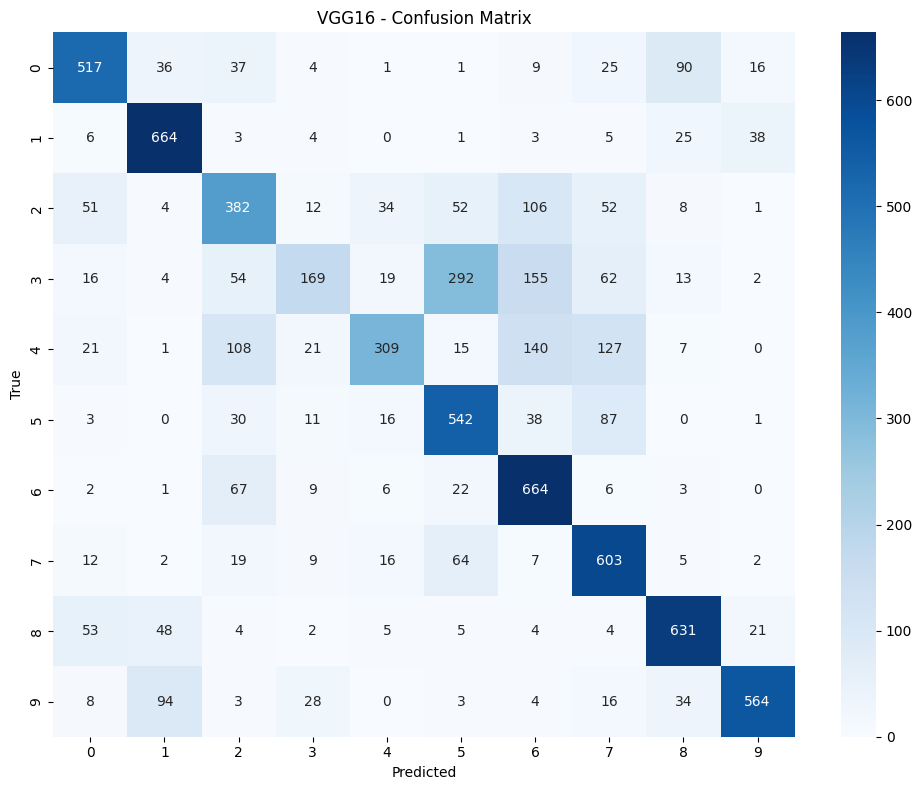

ROC-AUC Score: 0.9495


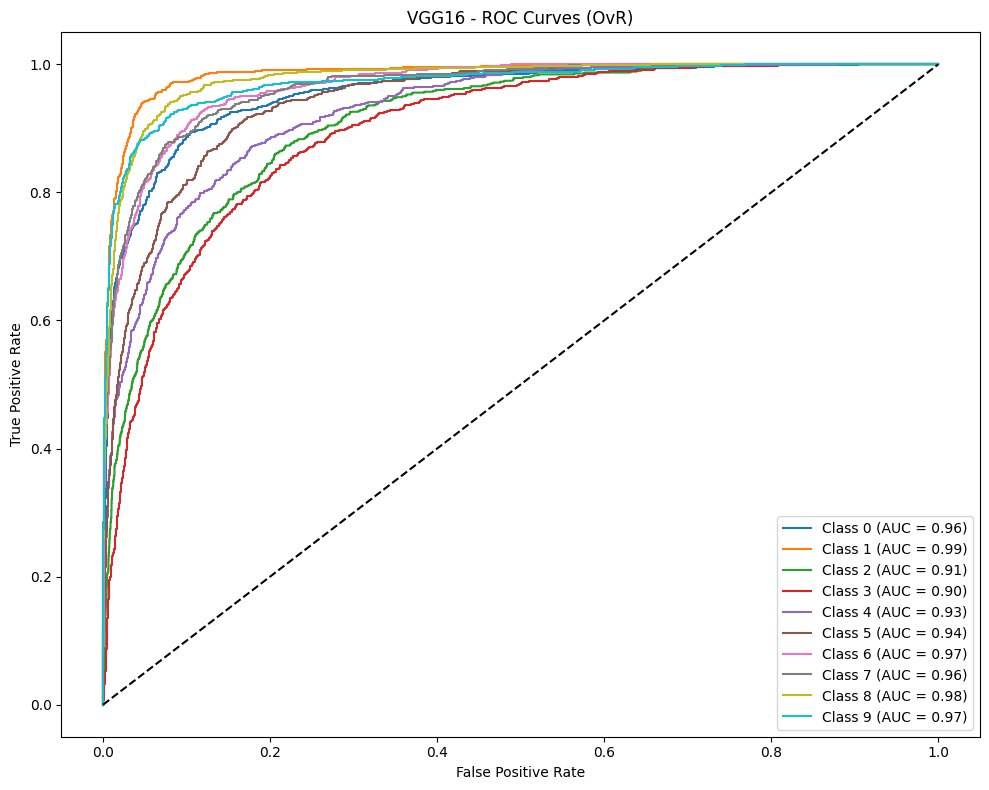


📊 Classification Report for VGG19
              precision    recall  f1-score   support

           0     0.7504    0.7024    0.7256       736
           1     0.7775    0.8865    0.8284       749
           2     0.5403    0.5442    0.5422       702
           3     0.6283    0.2150    0.3204       786
           4     0.7611    0.4126    0.5351       749
           5     0.5436    0.7445    0.6284       728
           6     0.5876    0.8513    0.6953       780
           7     0.6109    0.8160    0.6987       739
           8     0.7733    0.8121    0.7922       777
           9     0.8744    0.7480    0.8063       754

    accuracy                         0.6727      7500
   macro avg     0.6847    0.6733    0.6573      7500
weighted avg     0.6858    0.6727    0.6570      7500



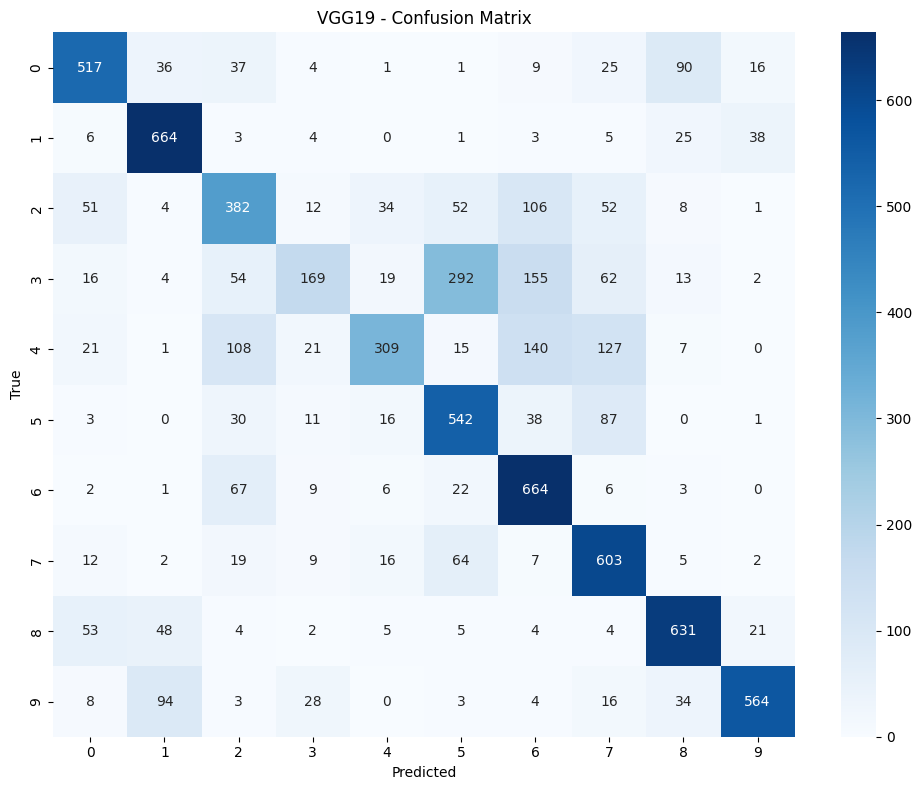

ROC-AUC Score: 0.9495


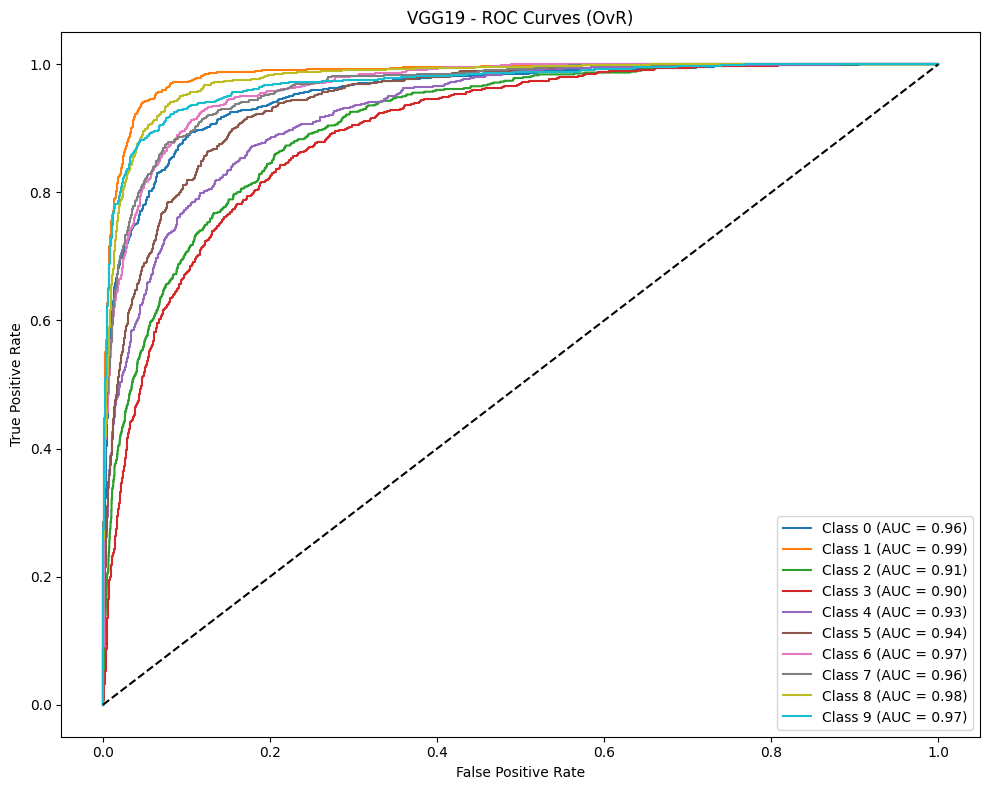


📊 Classification Report for RESNET50
              precision    recall  f1-score   support

           0     0.7504    0.7024    0.7256       736
           1     0.7775    0.8865    0.8284       749
           2     0.5403    0.5442    0.5422       702
           3     0.6283    0.2150    0.3204       786
           4     0.7611    0.4126    0.5351       749
           5     0.5436    0.7445    0.6284       728
           6     0.5876    0.8513    0.6953       780
           7     0.6109    0.8160    0.6987       739
           8     0.7733    0.8121    0.7922       777
           9     0.8744    0.7480    0.8063       754

    accuracy                         0.6727      7500
   macro avg     0.6847    0.6733    0.6573      7500
weighted avg     0.6858    0.6727    0.6570      7500



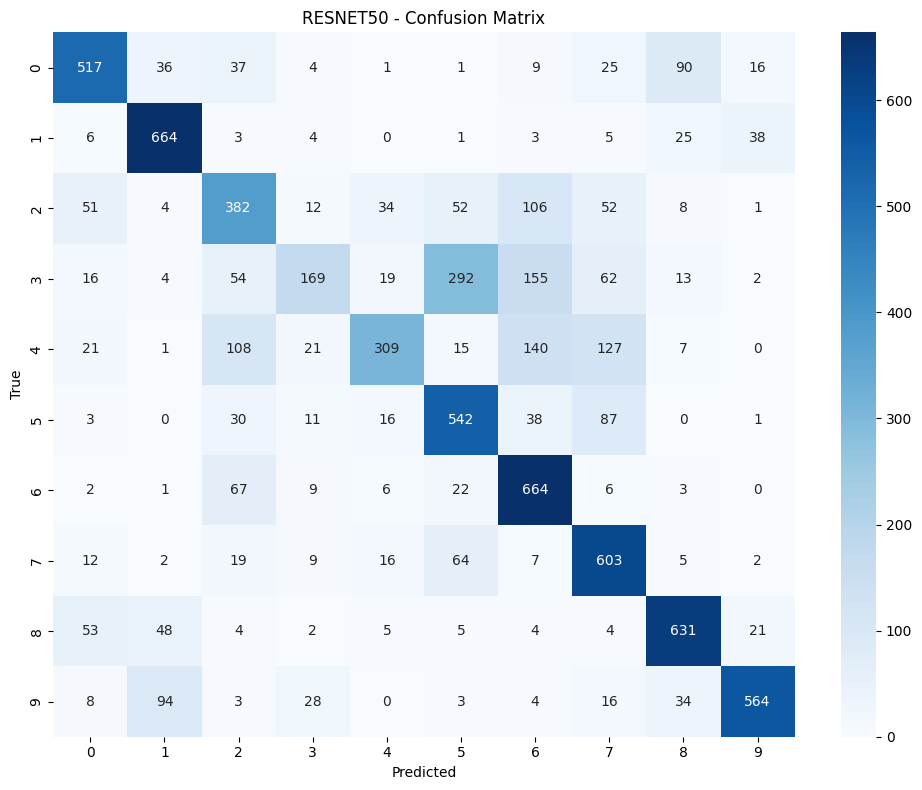

ROC-AUC Score: 0.9495


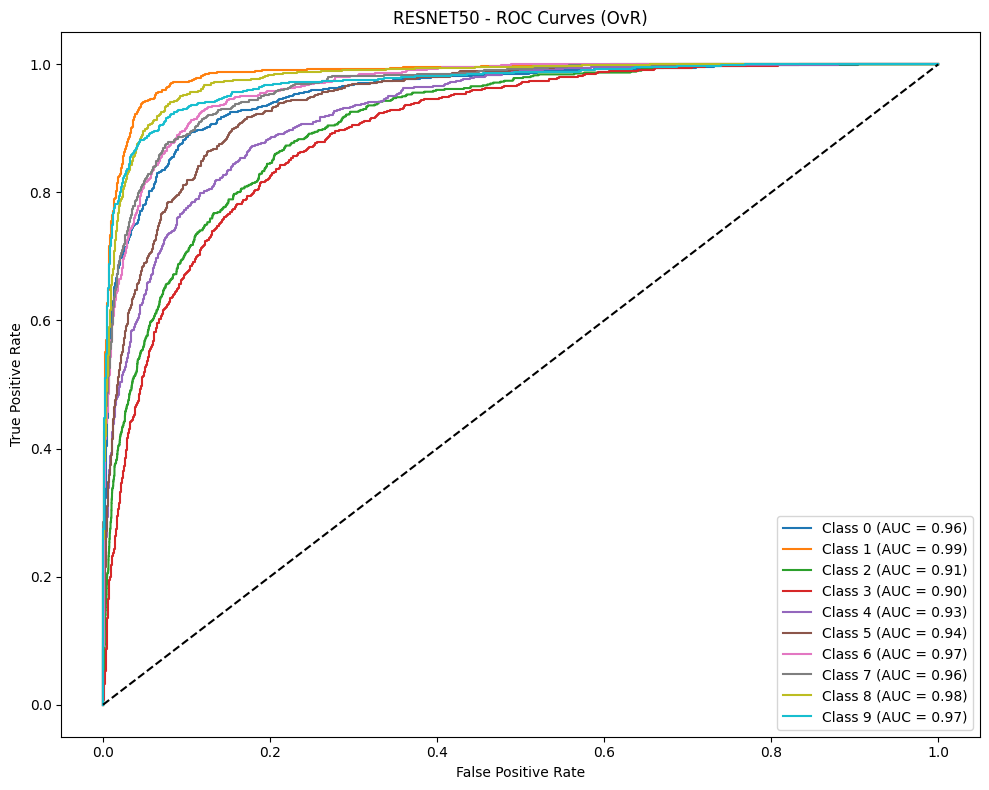

In [ ]:
for name in model_names:

    # Run full evaluation
    full_evaluation(model, test_loader, model_name=name)